# Question 1: Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

## Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

## 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
import seaborn as sns
import networkx as nx
from networkx.algorithms import bipartite
from networkx.algorithms import max_weight_matching
%matplotlib inline

<span style="color:blue"> First, we load our data into a dataframe, *lalonde*. 

In [98]:
lalonde = pd.read_csv('lalonde.csv', index_col=0)
lalonde.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


<span style="color:blue">In order to make the data more clear, we create a *race* column that replaces the *black* and *hisp* columns. It permits to directly access the information: 0 for "black", 1 for "hispanic", 2 for "white" (neither black nor hispanic). We also replace the *nodegree* column by a *degree* column, to invert the sense and make it more consistent with other features such as *married*, where 0 means "not married" whereas for *nodegree*, 0 means "no no degree = degree".



In [99]:
lalonde['race'] = 2-lalonde['hispan']-2*lalonde['black'] #black race: 0, hispanic: 1, white: 2
lalonde['degree'] = 1+lalonde['nodegree']*-1 #inversing the nodegree column 

del lalonde['nodegree'] #removing the unnecessary columns
del lalonde['black']
del lalonde['hispan']

lalonde = lalonde[['treat', 'age', 'educ', 'married', 'race', 'degree', 're74', 're75', 're78']]
lalonde.head()

,treat,age,educ,married,race,degree,re74,re75,re78
id,,,,,,,,,
NSW1,1,37,11,1,0,0,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,0.0,0.0,3595.8940
NSW3,1,30,12,0,0,1,0.0,0.0,24909.4500
NSW4,1,27,11,0,0,0,0.0,0.0,7506.1460
NSW5,1,33,8,0,0,0,0.0,0.0,289.7899


<span style="color:blue">We also create 2 dataframes, *treat* and *no_treat*, to separate subject according to their completion of the program or not.

In [100]:
treat = lalonde[lalonde['treat']==1]     #only people who completed the program
no_treat = lalonde[lalonde['treat']==0]
treat.describe()

,treat,age,educ,married,race,degree,re74,re75,re78
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.189189,0.254054,0.291892,2095.573689,1532.055314,6349.143530
std,0.0,7.155019,2.010650,0.392722,0.621444,0.455867,4886.620353,3219.250870,7867.402218
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800
50%,1.0,25.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4232.309000
75%,1.0,29.000000,12.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000
max,1.0,48.000000,16.000000,1.000000,2.000000,1.000000,35040.070000,25142.240000,60307.930000


<span style="color:blue">Let's observe the difference in revenue in 1978 between people who completed the program and those who did not:

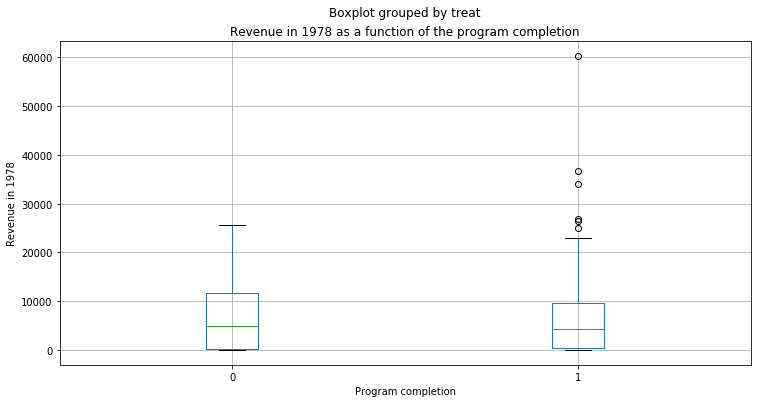

In [101]:
ax = lalonde.boxplot(column = ['re78'], by = ['treat'] ,figsize=(12,6))
ax.set_xlabel('Program completion')
ax.set_ylabel('Revenue in 1978')
ax.set_title('Revenue in 1978 as a function of the program completion')

<span style="color:blue">WRITE OBSERVATION AND CONCLUSION HERE

## 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

<span style="color:blue">We implement several boxplots, one for each features, grouped by the *treat* feature.

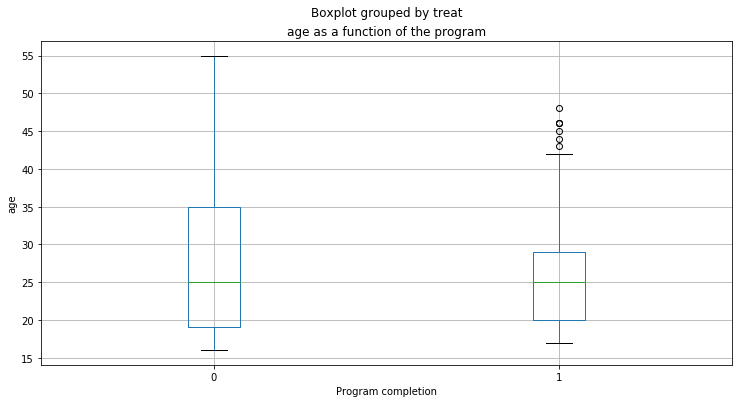

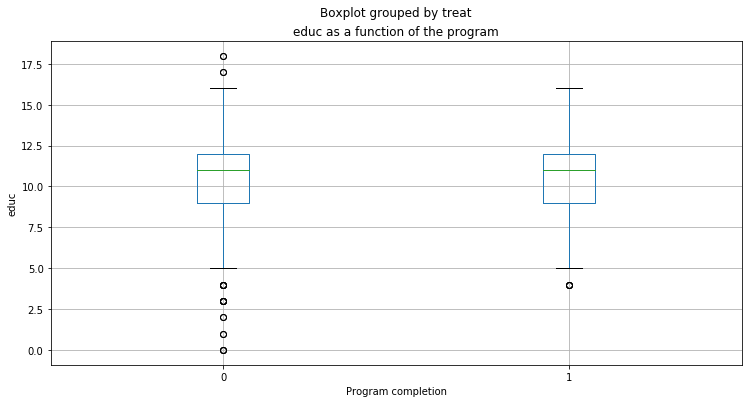

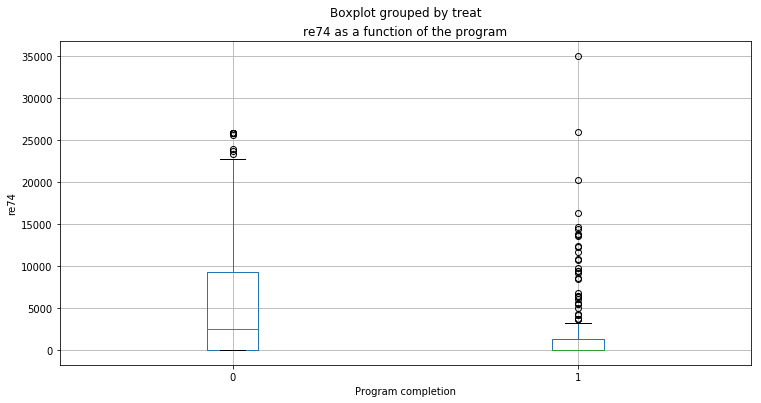

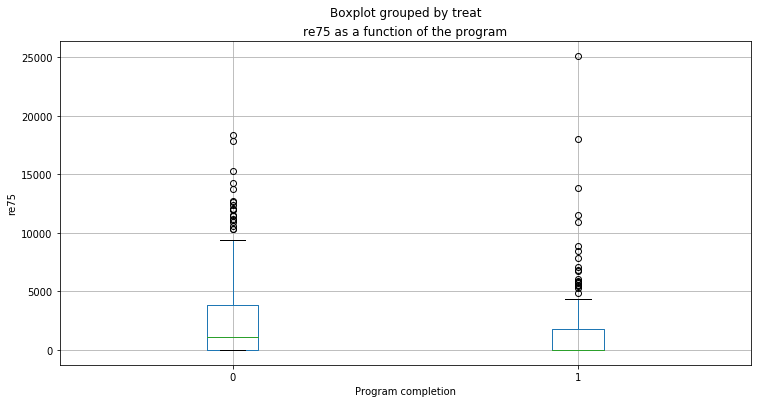

In [102]:
for features in ['age', 'educ', 're74', 're75']:

    ax = lalonde.boxplot(column = [features], by = ['treat'] ,figsize=(12,6))
    ax.set_xlabel('Program completion')
    ax.set_ylabel(features)
    ax.set_title(features+ ' as a function of the program')

<span style="color:blue">We also compute several pie charts for the tertiary/binary features *race*, *married* and *degree*.

1
2
3


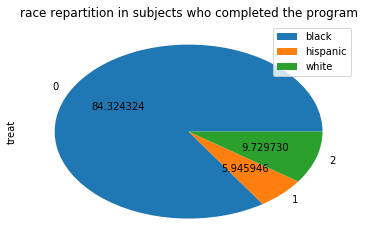

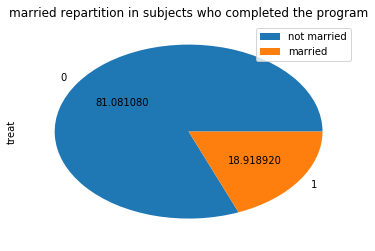

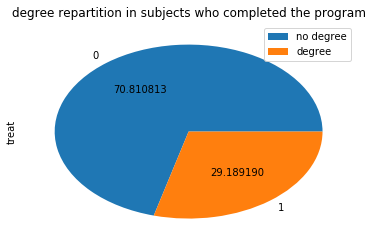

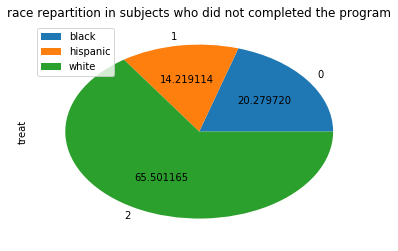

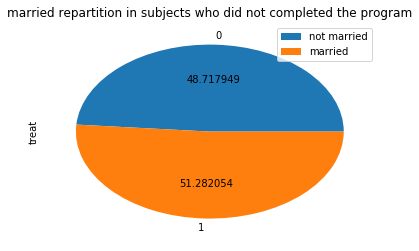

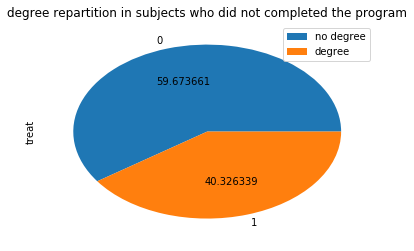

In [103]:
a=0
b=0
legend = [['black', 'hispanic', 'white'],['not married', 'married'],['no degree', 'degree']]

for features in ['race', 'married', 'degree']:

    pie = treat.groupby(features).count().plot.pie(y='treat', autopct="%2f").legend(labels=legend[a] , loc="best")
    plt.title(features+' repartition in subjects who completed the program')
    a+=1
    print(a)
    
for features in ['race', 'married', 'degree']:
    
    pie = no_treat.groupby(features).count().plot.pie(y='treat', autopct="%2f").legend(labels=legend[b] , loc="best")
    plt.title(features+' repartition in subjects who did not completed the program')
    b+=1
    

<span style="color:blue">WRITE OBSERVATION AND CONCLUSION HERE

## 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)

<span style="color:blue"> Here the linear regression model is created and trained. This model will enables us to obtain propensity scores for all points in the dataset. 

In [104]:
feature_cols = ['age', 'educ', 'married', 'race', 'degree', 're74', 're75', 're78']
X = lalonde[feature_cols]
y = lalonde.treat

logistic = linear_model.LogisticRegression()
logistic.fit(X,y) # train the model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

<span style="color:blue"> The evaluation of the precision is done with cross-validation

In [105]:
precision = cross_val_score(logistic, X, y, cv=10, scoring = "precision")
recall = cross_val_score(logistic, X, y, cv=10, scoring = "recall")

print("Precision: %0.2f (+/- %0.2f)" % (precision.mean(), precision.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (recall.mean(), recall.std() * 2))

Precision: 0.62 (+/- 0.47)
Recall: 0.70 (+/- 0.50)


<span style="color:blue"> Here we use the function predict_proba to evaluate the propability of each subject to belong in treat or non treat class. The probability of belonging to the positive class (treat == 1) gives the propensy score.

In [121]:
# Probability of belonging to class
prediction = logistic.predict_proba(X) 
print(logistic.classes_) # to see which column corresponds to which class, the positive case corresponds to column 1
lalonde['propensy_score'] = pd.Series(prediction[:,1], index = lalonde.index)
lalonde.head()

[0 1]


,treat,age,educ,married,race,degree,re74,re75,re78,propensy_score
id,,,,,,,,,,
NSW1,1,37,11,1,0,0,0.0,0.0,9930.0460,0.650040
NSW2,1,22,9,0,1,0,0.0,0.0,3595.8940,0.287830
NSW3,1,30,12,0,0,1,0.0,0.0,24909.4500,0.784361
NSW4,1,27,11,0,0,0,0.0,0.0,7506.1460,0.724448
NSW5,1,33,8,0,0,0,0.0,0.0,289.7899,0.642385


## 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

<span style="color:blue"> In order to match the data from the treated group with exactly one data point from the control group, the networkx pakage is used. The module bipartite is used in order to have two node sets (treated and non treated) and edges that only connect nodes from opposite sets. Added nodes correspond to indexes of the lalong dataset. The edges correspond to all the possible connexions between nodes from treated side with nodes from untreated side. Each edge has a weight wich corresponds to 1 - abs(propensy_score(node1) - propensy_score(node2)). Therefore the weight interval is [0,1], with 1 being the highest weight.

In [107]:
G = nx.Graph()
G.add_nodes_from(lalonde.index[lalonde.treat == 0], bipartite = 0)
G.add_nodes_from(lalonde.index[lalonde.treat == 1], bipartite = 1)


#Add edges with weight, as the max weight matching function will match with maximum weight, we do 1 - the difference of propensy score
# As such, the weight is maximum if 1 and minimum if 0.
for node0, weight0 in zip(lalonde.index[lalonde.treat == 0], lalonde.propensy_score[lalonde.treat == 0]):
    for node1, weigth1 in zip(lalonde.index[lalonde.treat == 1], lalonde.propensy_score[lalonde.treat == 1]):
        G.add_edge(node0, node1, weight = 1- abs(weight0 - weigth1))

<span style="color:blue"> In order to do matching, the max_weight_matching function is used. It computes a maximum-weighted matching of the graph created by using the weights added to the edges. The matching has the particularity that no node occurs more than once. Maxcardinality parameter is set to true in order to compute the maximum-cardinality matching with maximum weight among all maximum-cardinality matchings.

In [122]:
# max_weight_matching
match = nx.max_weight_matching(G, maxcardinality = True)

In [109]:
match

{'NSW1': 'PSID182',
 'NSW10': 'PSID288',
 'NSW100': 'PSID96',
 'NSW101': 'PSID110',
 'NSW102': 'PSID177',
 'NSW103': 'PSID293',
 'NSW104': 'PSID46',
 'NSW105': 'PSID411',
 'NSW106': 'PSID266',
 'NSW107': 'PSID386',
 'NSW108': 'PSID373',
 'NSW109': 'PSID326',
 'NSW11': 'PSID368',
 'NSW110': 'PSID331',
 'NSW111': 'PSID40',
 'NSW112': 'PSID357',
 'NSW113': 'PSID157',
 'NSW114': 'PSID412',
 'NSW115': 'PSID384',
 'NSW116': 'PSID124',
 'NSW117': 'PSID271',
 'NSW118': 'PSID426',
 'NSW119': 'PSID84',
 'NSW12': 'PSID220',
 'NSW120': 'PSID21',
 'NSW121': 'PSID179',
 'NSW122': 'PSID389',
 'NSW123': 'PSID428',
 'NSW124': 'PSID29',
 'NSW125': 'PSID276',
 'NSW126': 'PSID427',
 'NSW127': 'PSID238',
 'NSW128': 'PSID94',
 'NSW129': 'PSID216',
 'NSW13': 'PSID45',
 'NSW130': 'PSID345',
 'NSW131': 'PSID173',
 'NSW132': 'PSID8',
 'NSW133': 'PSID339',
 'NSW134': 'PSID385',
 'NSW135': 'PSID31',
 'NSW136': 'PSID158',
 'NSW137': 'PSID212',
 'NSW138': 'PSID354',
 'NSW139': 'PSID211',
 'NSW14': 'PSID207',
 'NSW1

In [110]:
nx.is_connected(G)
# Obtain the bipartite sets
bottom_nodes, top_nodes = bipartite.sets(G)
bottom_nodes

{'PSID1',
 'PSID10',
 'PSID100',
 'PSID101',
 'PSID102',
 'PSID103',
 'PSID104',
 'PSID105',
 'PSID106',
 'PSID107',
 'PSID108',
 'PSID109',
 'PSID11',
 'PSID110',
 'PSID111',
 'PSID112',
 'PSID113',
 'PSID114',
 'PSID115',
 'PSID116',
 'PSID117',
 'PSID118',
 'PSID119',
 'PSID12',
 'PSID120',
 'PSID121',
 'PSID122',
 'PSID123',
 'PSID124',
 'PSID125',
 'PSID126',
 'PSID127',
 'PSID128',
 'PSID129',
 'PSID13',
 'PSID130',
 'PSID131',
 'PSID132',
 'PSID133',
 'PSID134',
 'PSID135',
 'PSID136',
 'PSID137',
 'PSID138',
 'PSID139',
 'PSID14',
 'PSID140',
 'PSID141',
 'PSID142',
 'PSID143',
 'PSID144',
 'PSID145',
 'PSID146',
 'PSID147',
 'PSID148',
 'PSID149',
 'PSID15',
 'PSID150',
 'PSID151',
 'PSID152',
 'PSID153',
 'PSID154',
 'PSID155',
 'PSID156',
 'PSID157',
 'PSID158',
 'PSID159',
 'PSID16',
 'PSID160',
 'PSID161',
 'PSID162',
 'PSID163',
 'PSID164',
 'PSID165',
 'PSID166',
 'PSID167',
 'PSID168',
 'PSID169',
 'PSID17',
 'PSID170',
 'PSID171',
 'PSID172',
 'PSID173',
 'PSID174',
 '

<span style="color:blue"> Here a new dataset containing only the matched elements is created. This will allow us to compute the same observations as done in points 1.1 and 1.2

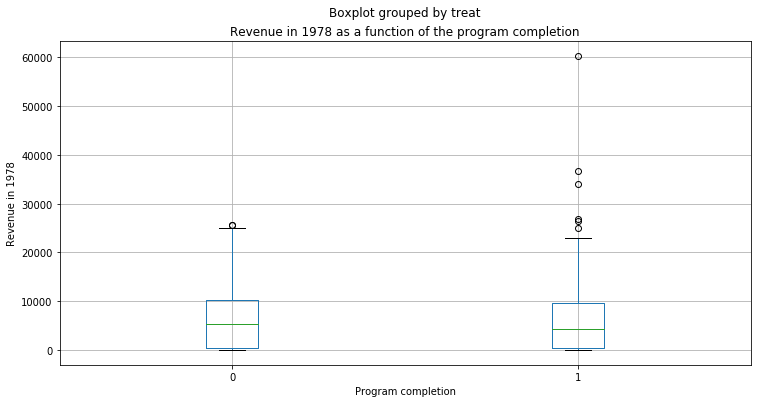

In [120]:
# Compare outcome re78 between the two groups

lalonde_matched = lalonde.loc[list(match.keys())]

ax = lalonde_matched.boxplot(column = ['re78'], by = ['treat'] ,figsize=(12,6))
ax.set_xlabel('Program completion')
ax.set_ylabel('Revenue in 1978')
ax.set_title('Revenue in 1978 as a function of the program completion')

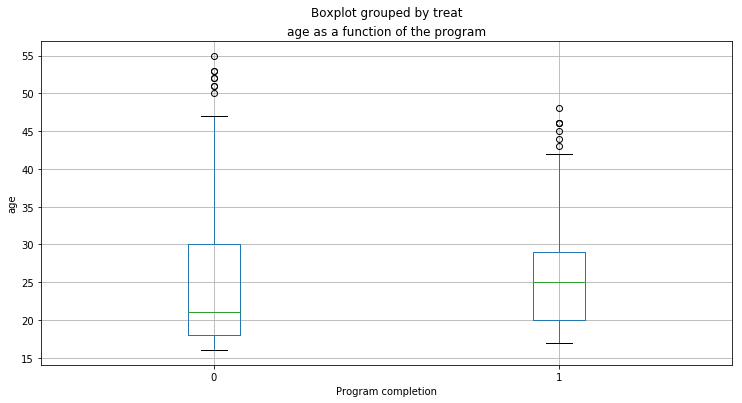

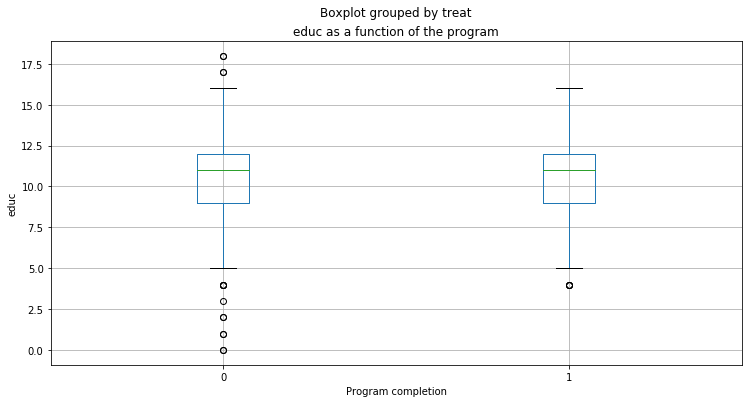

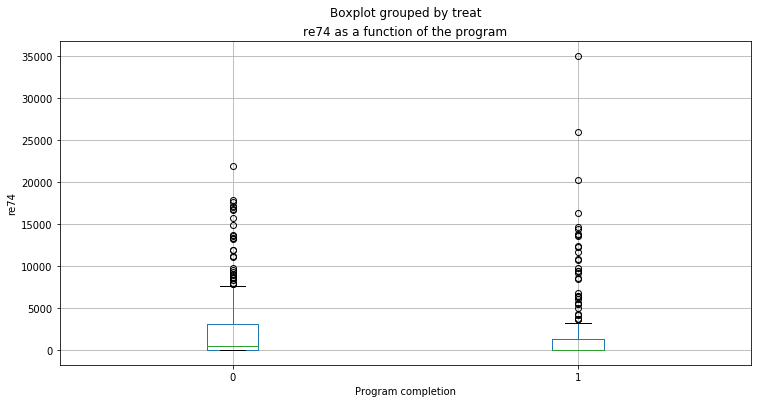

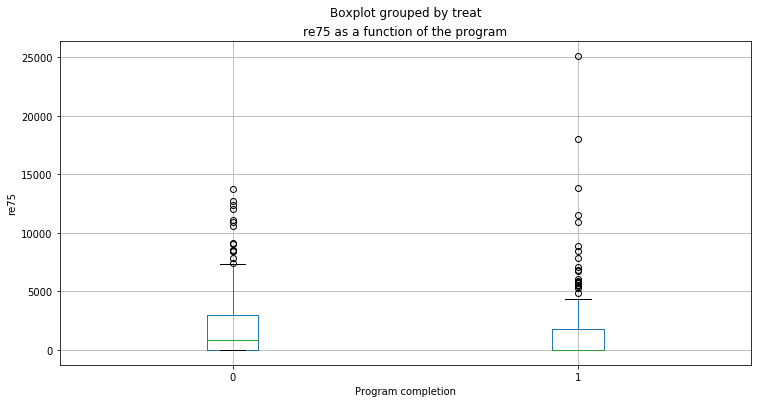

In [118]:
for features in ['age', 'educ', 're74', 're75']:

    ax = lalonde_matched.boxplot(column = [features], by = ['treat'] ,figsize=(12,6))
    ax.set_xlabel('Program completion')
    ax.set_ylabel(features)
    ax.set_title(features+ ' as a function of the program')

1
2
3


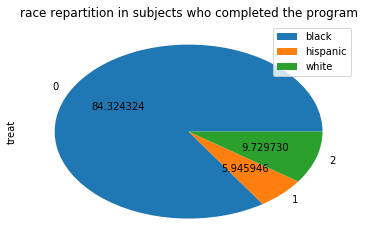

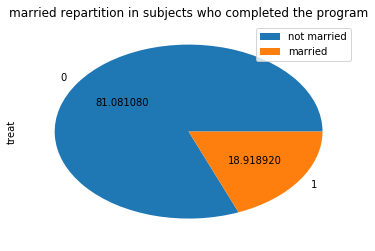

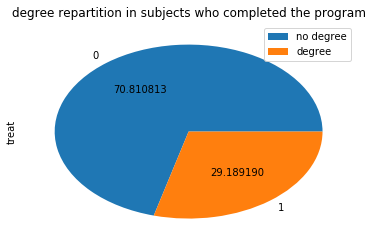

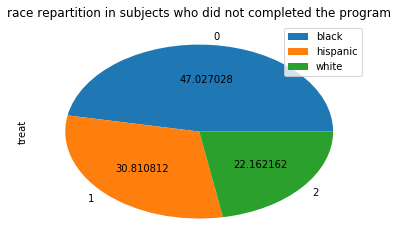

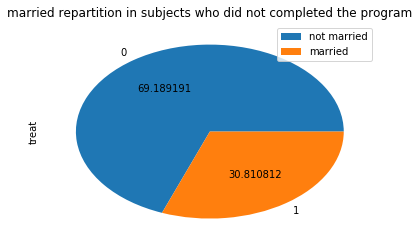

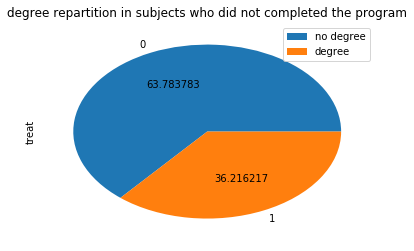

In [114]:
treated = lalonde_matched[lalonde_matched['treat']==1]     #only people who completed the program
no_treated = lalonde_matched[lalonde_matched['treat']==0]

a=0
b=0
legend = [['black', 'hispanic', 'white'],['not married', 'married'],['no degree', 'degree']]

for features in ['race', 'married', 'degree']:

    pie = treated.groupby(features).count().plot.pie(y='treat', autopct="%2f").legend(labels=legend[a] , loc="best")
    plt.title(features+' repartition in subjects who completed the program')
    a+=1
    print(a)
    
for features in ['race', 'married', 'degree']:
    
    pie = no_treated.groupby(features).count().plot.pie(y='treat', autopct="%2f").legend(labels=legend[b] , loc="best")
    plt.title(features+' repartition in subjects who did not completed the program')
    b+=1

<span style="color:blue">There are still huge differences in race repartition between the two groups.

TODO: Analysis of the graphs AND define the problematic feature(s)

## 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.

The problematic feature: race, age, re75, re74?

## 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

# Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

## 1. Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

## 2. Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.